# Task 1: Mangrove Cover Analysis
Automation of the analysis of mangrove cover

In [ ]:
# Install dependencies if needed
#!pip install -r requirements.txt

In [12]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import rasterio.features
import numpy as np
from rasterio.plot import show
from rasterio.warp import calculate_default_transform, reproject, Resampling
import base64
from PIL import Image
import io

## Simple plotting

In [13]:
# Load the AOI GeoJSON
aoi = gpd.read_file("data_in/mangroves_case_study.geojson")

# Load the GMW TIFF files for 2016 to 2020
gmw_files = {
    "2016": "data_in/gmw_2016.tif",
    "2017": "data_in/gmw_2017.tif",
    "2018": "data_in/gmw_2018.tif",
    "2019": "data_in/gmw_2019.tif",
    "2020": "data_in/gmw_2020.tif",
}

cropped_tiffs = {}

for year, file in gmw_files.items():
    with rasterio.open(file) as src:
        cropped, _ = mask(src, aoi.geometry, crop=True)
        cropped_tiffs[year] = cropped

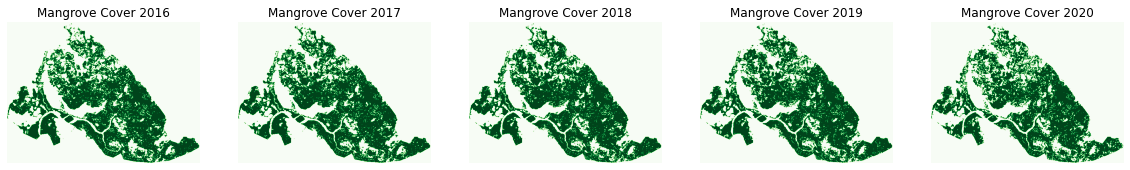

In [14]:
fig, axs = plt.subplots(1, 5, figsize=(20, 8))

for idx, (year, tiff) in enumerate(cropped_tiffs.items()):
    ax = axs[idx]
    ax.imshow(tiff[0], cmap='Greens')
    ax.set_title(f"Mangrove Cover {year}")
    ax.axis('off')

plt.show()

## Export of cropped rasters

In [15]:
for year, file in gmw_files.items():
    with rasterio.open(file) as src:
        # Mask the raster with the AOI
        out_image, out_transform = mask(src, aoi.geometry, crop=True)
        
        # Update metadata for cropped raster
        out_meta = src.meta.copy()
        out_meta.update({
            "driver": "GTiff",
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform
        })
        
        # Save the cropped raster
        out_filepath = f"data_out/aoi_gmw_{year}.tif"
        with rasterio.open(out_filepath, "w", **out_meta) as dest:
            dest.write(out_image)

## Reprojection

In [16]:
# Load and reproject the AOI
desired_crs = 'EPSG:32630'  # Update as needed for the specific region
aoi_projected = aoi.to_crs(desired_crs)
aoi_projected.to_file("data_out/reprojected_aoi.geojson", driver='GeoJSON')

# Define paths for existing and new rasters
cropped_files = {
    "2016": "data_out/aoi_gmw_2016.tif",
    "2017": "data_out/aoi_gmw_2017.tif",
    "2018": "data_out/aoi_gmw_2018.tif",
    "2019": "data_out/aoi_gmw_2019.tif",
    "2020": "data_out/aoi_gmw_2020.tif",
}
reprojected_files = {year: f"data_out/reprojected_aoi_gmw_{year}.tif" for year in cropped_files}

# Reproject each raster to the desired CRS
for year, input_path in cropped_files.items():
    with rasterio.open(input_path) as src:
        transform, width, height = calculate_default_transform(
            src.crs, desired_crs, src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': desired_crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        with rasterio.open(reprojected_files[year], 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=desired_crs,
                    resampling=Resampling.nearest)

## Calculation

In [17]:
# Calculate forest coverage percentages
forest_coverage_percentages = {}
for year, file_path in reprojected_files.items():
    with rasterio.open(file_path) as src:
        aoi_area = aoi_projected.geometry.area.sum()  # Calculate the area of the AOI in square meters
        data = src.read(1)  # Read the first band
        pixel_area = src.res[0] * src.res[1]  # Area of a single pixel in square meters
        forest_pixels = np.sum(data == 1)  # Count pixels with value 1
        forest_area = forest_pixels * pixel_area  # Total area covered by forest
        forest_coverage_percentage = (forest_area / aoi_area) * 100
        forest_coverage_percentages[year] = forest_coverage_percentage

forest_coverage_details = {}
for year, file_path in reprojected_files.items():
    with rasterio.open(file_path) as src:
        aoi_area = aoi_projected.geometry.area.sum()  # in square meters
        data = src.read(1)  # Read the first band
        pixel_area = src.res[0] * src.res[1]  # Area of a single pixel in square meters
        
        forest_pixels = np.sum(data == 1)  # Count pixels with value 1 (indicating forest)
        forest_area_m2 = forest_pixels * pixel_area  # Total area covered by forest in square meters
        forest_area_ha = forest_area_m2 / 10000  # Convert area from m² to hectares
        forest_area_km2 = forest_area_m2 / 1000000  # Convert area from m² to square kilometers
        
        forest_coverage_percentage = (forest_area_m2 / aoi_area) * 100
        forest_coverage_details[year] = {
            "percentage": forest_coverage_percentage,
            "area_ha": forest_area_ha,
            "area_km2": forest_area_km2
        }


## Graph

In [18]:
# Open your image file
with open('data_in/logo.png', 'rb') as image_file:
    encoded_string = base64.b64encode(image_file.read()).decode()

# Create the base64 string for HTML embedding
logo_url = 'data:image/png;base64,' + encoded_string

# Prepare data for plotting with additional hover data
data_for_plot = [{
    "Year": year,
    "Mangrove Coverage (%)": details["percentage"],
    "Area (ha)": details["area_ha"],
    "Area (km²)": details["area_km2"]
} for year, details in forest_coverage_details.items()]

# Create the Plotly bar chart with custom hover data
fig = px.bar(
    data_for_plot,
    x="Year",
    y="Mangrove Coverage (%)",
    title="Mangrove Coverage Over Time",
    color_discrete_sequence=["#9EEC75"],
    hover_data={
        "Area (ha)": ':.2f',  # Format to 2 decimal places
        "Area (km²)": ':.3f'  # Format to 3 decimal places
    }
)

# Enhance chart with labels and a more refined layout
fig.update_layout(
    xaxis_title="Year",
    yaxis_title="% of Mangrove in AOI",
    xaxis=dict(tickmode='linear'),
    yaxis=dict(range=[60, 65]),  # Focus on the range 60-65% if needed
    coloraxis_showscale=False,
    width=500,
    height=400,
    bargap=0.6,
    margin=dict(l=60, r=60, t=100, b=70),
    images=[dict(
        source=logo_url,
        xref="paper", yref="paper",
        x=1, y=1.05,  # You can adjust x and y to position your image
        sizex=0.2, sizey=0.2,  # Adjust the size as needed
        xanchor="right", yanchor="bottom"
    )]
)

fig.show()


## Text description

In [19]:
# Calculate the total area of the AOI just once, as it doesn't change
total_aoi_area_m2 = aoi_projected.geometry.area.sum()  # in square meters
total_aoi_area_ha = total_aoi_area_m2 / 10000  # Convert area from m² to hectares
total_aoi_area_km2 = total_aoi_area_m2 / 1000000  # Convert area from m² to square kilometers

# Print a header for clarity
print("Summary of Forest Coverage in the AOI Over Time:\n")
print(f"Total Area of AOI: {total_aoi_area_ha:.2f} hectares ({total_aoi_area_km2:.3f} km²)\n")
print("{:<6} {:<20} {:<20} {:<20}".format("Year", "Coverage (%)", "Area (ha)", "Area (km²)"))

# Loop through each year and print the details
for year, details in forest_coverage_details.items():
    print("{:<6} {:<20.2f} {:<20.2f} {:<20.3f}".format(
        year, 
        details["percentage"], 
        details["area_ha"], 
        details["area_km2"]
    ))

# Calculate and print any trends or significant observations
years = list(forest_coverage_details.keys())
starting_year, ending_year = years[0], years[-1]
starting_coverage, ending_coverage = forest_coverage_details[starting_year]["percentage"], forest_coverage_details[ending_year]["percentage"]

print("\nObservations:")
print(f"From {starting_year} to {ending_year}, the forest coverage percentage changed from {starting_coverage:.2f}% to {ending_coverage:.2f}%.")

# Detect significant changes
if ending_coverage > starting_coverage:
    print("This indicates an increase in forest coverage, suggesting positive conservation outcomes or regrowth.")
elif ending_coverage < starting_coverage:
    print("This indicates a decrease in forest coverage, which might suggest deforestation or degradation of forest areas.")
else:
    print("There has been no significant change in forest coverage.")

# Highest and lowest coverage
highest_year = max(forest_coverage_details, key=lambda x: forest_coverage_details[x]["percentage"])
lowest_year = min(forest_coverage_details, key=lambda x: forest_coverage_details[x]["percentage"])
print(f"The highest forest coverage was in {highest_year} with {forest_coverage_details[highest_year]['percentage']:.2f}%.")
print(f"The lowest forest coverage was in {lowest_year} with {forest_coverage_details[lowest_year]['percentage']:.2f}%.")


Summary of Forest Coverage in the AOI Over Time:

Total Area of AOI: 8617.47 hectares (86.175 km²)

Year   Coverage (%)         Area (ha)            Area (km²)          
2016   62.89                5419.09              54.191              
2017   63.90                5506.53              55.065              
2018   64.73                5578.12              55.781              
2019   63.88                5504.71              55.047              
2020   61.71                5317.82              53.178              

Observations:
From 2016 to 2020, the forest coverage percentage changed from 62.89% to 61.71%.
This indicates a decrease in forest coverage, which might suggest deforestation or degradation of forest areas.
The highest forest coverage was in 2018 with 64.73%.
The lowest forest coverage was in 2020 with 61.71%.
